In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import time
import progressbar
from datetime import datetime
import networkx as nx
import scipy.spatial
import math
import scipy.stats
import gc

import os
import seaborn as sn
from sklearn import preprocessing

%matplotlib inline
from shapely.geometry import Polygon
start = datetime.now()

## Frames do FETW 

In [2]:
path_original = ""

In [3]:
all_games_og = pd.read_csv(f'all_games_other_games.csv')

In [4]:
partidas = all_games_og.partida.unique()

In [42]:
partidas

array(['REDSCAT2'], dtype=object)

In [6]:
all_games_ad = all_games_og[all_games_og['interval_frame_size'] >= 500]

In [7]:
all_games_ad.reset_index().to_csv('all_games_ad_FETW.csv')

In [9]:
#Função que pega a posição dos jogadores só dos intervalos de FETW
def get_FETW_interval(FETW_ini,FETW_end):
    list_player.append(players_positions.iloc[FETW_ini:FETW_end])

## Gerando e salvando as imagens

In [10]:
def valid_FETW_target():
    target = all_games[(all_games.partida == partida) & (all_games['index'] == int(file.split('_')[0]))].target.values[0]
    return int(target)

In [11]:
def generate_rhythm(df, name):
    
    team = name.split("_")[-1]
    name = name.replace(team, '')
    
    #Tira as legendas e define a palheta de cores
    figure = sn.heatmap(df.values, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)
    #figure = sn.heatmap(df.values, cmap="gray", cbar=False, xticklabels=False, yticklabels=False) #Fazendo as imagens cinzas
    
    filename = 'rhythm_figures/graph_metric/' + partida
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    figure.figure.savefig(filename + '/' +
                          str(FETW_count) + '_' + 
                          str(name).replace('_','') + '_' + 
                          team + '_' + str(valid_FETW_target()) + '.jpg',bbox_inches='tight', pad_inches=0)
                          
    #str(valid_FETW_target()) + '/' + partida + '_' + file.split('.')[0] + '.png',bbox_inches='tight', pad_inches=0)
    return figure

In [12]:
def normalize_data(metric):
    #Normalizing values
    x = metric.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df = df.reindex(df.mean(axis=1).sort_values(ascending=True).index, axis=0)
    
    return df

In [13]:
def get_metric_list(atributo):
    all_nodes_matrix = []
    for m_graph in (graph_group):
        node_array = []
        for node in m_graph:
            node_array.append(m_graph.nodes[node][atributo])
        all_nodes_matrix.append(node_array)

    return all_nodes_matrix

In [14]:
def create_df_metrics(all_nodes_matrix):
    i=0
    matrix_t1 = []
    matrix_t2 = []
    
    while i < len(all_nodes_matrix):
        matrix_t1.append(all_nodes_matrix[i])
        matrix_t2.append(all_nodes_matrix[i+1])
        i = i+2

    #Adicionando a centralidade dos times
    df_matrix_t1 = pd.DataFrame(matrix_t1)
    df_matrix_t2 = pd.DataFrame(matrix_t2)

    return df_matrix_t1, df_matrix_t2

In [15]:
def node_neighbors(graph_indice, node):
    return ([n for n in graph_group[graph_indice].neighbors(node)])

In [16]:
def save_dataframe(df, name):
    team = name.split("_")[-1]
    name_rep = name.replace(team, '')
    
    path = 'grafo_all_bases\\' + partida +'\\'
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    path = path + '/' + str(FETW_count) + '_' + str(name_rep).replace('_','') + '_' + team +'.csv'
        
    df.to_csv(path)
    
    #Salvar as imagens
    #df = normalize_data(df)
    #generate_rhythm(df, name)


## Betweenness Centrality

In [17]:
# calcula a betweenness_centrality de cada node
def betweenness_centrality():
    for m_graph in (graph_group):
        bc = nx.betweenness_centrality(m_graph)
        for node in m_graph:
            m_graph.nodes[node]['bet_cen'] = bc[node]

    #Criando dataframes com centralidade
    bet_cen_matrix = get_metric_list('bet_cen')
    df_bet_cen_matrix_t1, df_bet_cen_matrix_t2 = create_df_metrics(bet_cen_matrix)
#     print(f'sizes: {len(df_bet_cen_matrix_t1.columns)} | {len(df_bet_cen_matrix_t2.columns)}')
    
    save_dataframe(df_bet_cen_matrix_t1, 'bet_cen_t1')
    save_dataframe(df_bet_cen_matrix_t2, 'bet_cen_t2')

## Eccentricity 

In [18]:
def eccentricity():
    #Calcula a Eccentricity de cada nó

    eccentricity_t1 = []
    eccentricity_t2 = []

    i = 0
    for m_graph in (graph_group):
        for node in m_graph:
            #Se o grafo nao for conexo coloca como 0
            if nx.is_connected(graph_group[i]):#Verifica se o grafo é conectado, se for adiciona o valor ao nó
                eccentricity_node = nx.algorithms.distance_measures.eccentricity(graph_group[i],node)
                m_graph.nodes[node]['eccentricity'] = eccentricity_node
            else:#Se o grafo nao for conectado adiciona 0 (n tem como calcular em grafo nao conectados)
                m_graph.nodes[node]['eccentricity'] = 0
        i+=1
    #Criando dataframe com as métricas
    eccentricity_matrix = get_metric_list('eccentricity')
    df_eccentricity_matrix_t1, df_eccentricity_matrix_t2 = create_df_metrics(eccentricity_matrix)
    
    save_dataframe(df_eccentricity_matrix_t1, 'eccentricity_t1')
    save_dataframe(df_eccentricity_matrix_t2, 'eccentricity_t2')

## Eficiencia Global

In [19]:
def eficiencia_global():
    #calcula a "global efficiency" de cada node
    for m_graph in (graph_group):
        for node in m_graph:
            global_efi =  []
            for comp_node in m_graph:
                if (comp_node != node):
                    global_efi.append(nx.efficiency(m_graph, node, comp_node))

            m_graph.nodes[node]['global_efficiency'] = sum(global_efi)/len(global_efi)
            
            #Criando dataframe com as métricas
    global_efficiency_matrix = get_metric_list('global_efficiency')
    df_global_efficiency_matrix_t1, df_global_efficiency_matrix_t2 = create_df_metrics(global_efficiency_matrix)
    
    save_dataframe(df_global_efficiency_matrix_t1, 'global_efficiency_t1')
    save_dataframe(df_global_efficiency_matrix_t2, 'global_efficiency_t2')

## Eficiencia Local

In [20]:
def eficiencia_local():
    i = 0
    for m_graph in (graph_group):  
        global_total = 0
        nodes_count = 0

        for node in m_graph:
            for node_atual in node_neighbors(i, node): #Soma todos os valores de Eficiencia Global
                global_total += graph_group[i].nodes[node_atual]['global_efficiency']
                nodes_count += 1

            if nodes_count != 0:
                graph_group[i].nodes[node]['loc_efficiency'] = (1 / nodes_count ) * global_total
                #Faz o calculo da eficiencia local de cada nó (Formula da Daniele)
            else:
                graph_group[i].nodes[node]['loc_efficiency'] = 0.001

        i += 1
    #Criando dataframe com as métricas
    loc_efficiency_matriz = get_metric_list('loc_efficiency')
    df_loc_efficiency_t1, df_loc_efficiency_t2 = create_df_metrics(loc_efficiency_matriz)
    
    save_dataframe(df_loc_efficiency_t1, 'loc_efficiency_t1')
    save_dataframe(df_loc_efficiency_t2, 'loc_efficiency_t2')

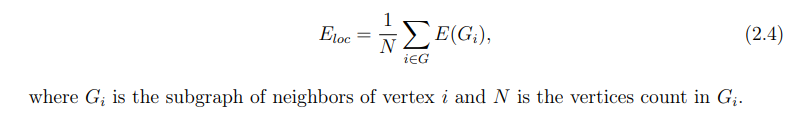

## Average Distance 

In [21]:
def distance():
    #Add Average Distance to graph
    i = 0
    for m_graph in (graph_group):
        if nx.is_connected(m_graph):
            ad = nx.average_shortest_path_length(m_graph)
        else:
            ad = 0
        for node in m_graph:
            graph_group[i].nodes[node]['aver_dist'] = ad
        i+=1
    #Criando dataframe com as métricas
    aver_dist_matriz = get_metric_list('aver_dist')
    df_aver_dist_matriz_t1, df_aver_dist_matriz_t2 = create_df_metrics(aver_dist_matriz)
    
    save_dataframe(df_aver_dist_matriz_t1, 'aver_dist_t1')
    save_dataframe(df_aver_dist_matriz_t2, 'aver_dist_t2')

## Vulnerability 

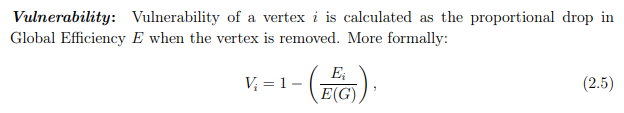

In [22]:
def vulnerability():
    #Calcula Vulnerability
    i = 0
    for m_graph in (graph_group):
        for node in m_graph:
            vulne = 1 - (graph_group[i].nodes[node]['global_efficiency'] / graph_group[i].nodes[node]['loc_efficiency'])
            m_graph.nodes[node]['vulnerability'] = vulne
        i+=1
    #Criando dataframe com as métricas
    vulnerability_matriz = get_metric_list('vulnerability')
    df_vulnerability_matriz_t1, df_vulnerability_matriz_t2 = create_df_metrics(vulnerability_matriz)
    
    save_dataframe(df_vulnerability_matriz_t1, 'vulnerability_t1')
    save_dataframe(df_vulnerability_matriz_t2, 'vulnerability_t2')

## Clustering 

In [23]:
def clustering():
    #Calculando clustering de cada nó
    i = 0
    for m_graph in (graph_group):
        for node in m_graph:
            node_clust = nx.algorithms.cluster.clustering(m_graph, node)
            graph_group[i].nodes[node]['clustering_coeffi'] = node_clust
        i+=1
    
    #Criando dataframe com as métricas
    clustering_coeffi_matriz = get_metric_list('clustering_coeffi')
    df_clustering_coeffi_matriz_t1, df_clustering_coeffi_matriz_t2 = create_df_metrics(clustering_coeffi_matriz)
    
    save_dataframe(df_clustering_coeffi_matriz_t1, 'clustering_coeffi_t1')
    save_dataframe(df_clustering_coeffi_matriz_t2, 'clustering_coeffi_t2')

## Rich Club Coefficient 

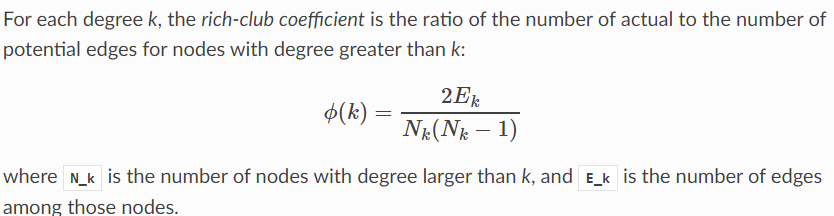

In [24]:
def rich_club_coefficient():
    #Calculando rich_club_coefficient de cada nó
    i = 0

    for m_graph in (graph_group):
        if have_newborns(m_graph) == True:
            graph_rich_club = nx.rich_club_coefficient(m_graph, normalized=False)
            for node in m_graph:
                graph_group[i].nodes[node]['rich_club_coefficient'] = graph_rich_club[0]
        else:
            for node in m_graph:
                graph_group[i].nodes[node]['rich_club_coefficient'] = 0
            
        i+=1
    #Criando dataframe com as métricas
    rich_club_coefficient_matriz = get_metric_list('rich_club_coefficient')
    df_rich_club_coefficient_matriz_t1, df_rich_club_coefficient_matriz_t2 = create_df_metrics(rich_club_coefficient_matriz)
    
    save_dataframe(df_rich_club_coefficient_matriz_t1, 'rich_club_coefficient_t1')
    save_dataframe(df_rich_club_coefficient_matriz_t2, 'rich_club_coefficient_t2')

In [25]:
def have_newborns(graph):
    if pd.Series(graph.degree()).apply(lambda x: x[0] * x[1]).sum() > 0:
        return True
    else:
        return False

## Grau 

In [26]:
def grau():
    #Calculando degree de cada nó
    i = 0
    for m_graph in (graph_group):
        for node in m_graph:
            node_degree = nx.classes.function.degree(m_graph, node)
            graph_group[i].nodes[node]['degree'] = node_degree
        i+=1
    #Criando dataframe com as métricas
    degree_matriz = get_metric_list('degree')
    df_degree_matriz_t1, df_degree_matriz_t2 = create_df_metrics(degree_matriz)
    
    save_dataframe(df_degree_matriz_t1, 'degree_t1')
    save_dataframe(df_degree_matriz_t2, 'degree_t2')

##  Diversity Entropy

In [27]:
def diversity_entropy():
    #Calculo da probabilidade de selecionar um nó entre todos os vizinhos
    i = 0
    for m_graph in (graph_group):
        for node in m_graph:
            if m_graph.nodes[node]['degree'] != 0:
                graph_group[i].nodes[node]['edge_probability'] = (1/(m_graph.nodes[node]['degree']))
            else:
                graph_group[i].nodes[node]['edge_probability'] = 0
        i+=1

    #Adiciona uma lista de vizinhos as variaveis de cada node, incluindo a probabilidade de passe para cada vizinho
    for m_graph in (graph_group):
        for node in m_graph:
            neighbor_nodes = []
            for neighbor_node in list(m_graph.neighbors(node)):
                neighbor_nodes.append([neighbor_node, m_graph.nodes[neighbor_node]['edge_probability']])
            m_graph.nodes[node]['neighbors'] = neighbor_nodes

    # calcula o array de probabilidades para os vizinhos dos vizinhos de cada node, e a entropia de cada node
    # utiliza estes ddos para cauculo da entropia de cada node
    for m_graph in (graph_group):
        for node in m_graph:
            edge_prob = m_graph.nodes[node]['edge_probability']
            prob_nei_of_nei = {}
            for node_neighbor in m_graph.nodes[node]['neighbors']:
                prob = edge_prob * node_neighbor[1]
                neigs_of_neig = list(m_graph.neighbors(node_neighbor[0]))
                for neig in neigs_of_neig:
                    if neig not in prob_nei_of_nei:
                        prob_nei_of_nei[neig] = prob
                    else:
                        prob_nei_of_nei[neig] = prob_nei_of_nei[neig] + prob
            m_graph.nodes[node]['list_prob_neig_of_neig'] = prob_nei_of_nei
            m_graph.nodes[node]['entropy'] = scipy.stats.entropy(list(prob_nei_of_nei.values()))
            
    #Criando dataframe com as métricas
    entropy_matriz = get_metric_list('entropy')
    df_entropy_matriz_t1, df_entropy_matriz_t2 = create_df_metrics(entropy_matriz)
    
    save_dataframe(df_entropy_matriz_t1, 'entropy_t1')
    save_dataframe(df_entropy_matriz_t2, 'entropy_t2')

## Page Rank 

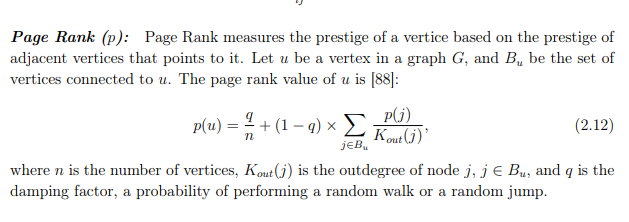

In [28]:
def pagerank():
    #Calculando pagerank de cada nó
    i = 0
    for m_graph in (graph_group):
        page_rank = nx.pagerank(m_graph)
        page_rank_indice = 0
        for node in m_graph:
            graph_group[i].nodes[node]['pagerank'] = page_rank[page_rank_indice]
            page_rank_indice += 1

        i+=1
        
    #Criando dataframe com as métricas
    pagerank_matriz = get_metric_list('pagerank')
    df_pagerank_matriz_t1, df_pagerank_matriz_t2 = create_df_metrics(pagerank_matriz)
    
    save_dataframe(df_pagerank_matriz_t1, 'pagerank_t1')
    save_dataframe(df_pagerank_matriz_t2, 'pagerank_t2')

## Criando o Gafo 

In [30]:
def create_graph():
    players_data = players_positions_FETW.copy()
    players_data = players_data.drop([0],axis=1)
    players_data.columns = [i+1 for i in range(len(players_data.columns))]
    players_data = players_data.transpose()

    def create_graph_nodes(row):
        position_list=[]
        G = nx.Graph()
        k = 0
        j = 0
        #Add the node "j", containing the argument "pos=x_coord, y_coord, for the fist team (k = 0 to 22)"
        while k < 28:
            #Apend the coordnates of the player to the postion list (will be used on a future opertion)
            if (row[k] > -100) & (row[k+1] > -100) & (G.number_of_nodes() < 11):
                position_list.append([row[k],row[k+1]])
                G.add_node(j, pos=(row[k],row[k+1]))
            j = j+1
            k = k+2
            
#         if G.number_of_nodes() > 11:
#             G.remove_node(list(G.nodes())[-1])
            
        #Apend the graph to the graph list
        graph_list.append(G)
        j=0
        # apend the position list for the current frame to the list of positions lists (will be used on a future opertion)
        group_of_position_lists.append(position_list)

        #Repeat all for the second team"
        G = nx.Graph()
        position_list=[]
        while k < 60:
            if (row[k] > -100) & (row[k+1] > -100) & (G.number_of_nodes() < 11):
                position_list.append([row[k],row[k+1]])
                G.add_node(j, pos=(row[k],row[k+1]))
            j = j+1
            k = k+2
                  
#         if G.number_of_nodes() > 11:
#             G.remove_node(list(G.nodes())[-1])
            
        graph_list.append(G)
        #will be used to generate delaunay trianges
        group_of_position_lists.append(position_list)
        return 0

    #Transform the dataset into a numpy_array and call the function above
    x= players_data.values
    np.apply_along_axis(create_graph_nodes, 0, x)

    #create a list of tuples, containing player positions
    for a_graph in (graph_list):
        list_pos.append(nx.get_node_attributes(a_graph,'pos'))

    for pos_list in (group_of_position_lists):
        triang_del_list.append(scipy.spatial.Delaunay(pos_list))

    #create edges from delaunay triangles

    # for each set of triangles
    i = 0
    for delTri in (triang_del_list):
        edges = set()
        # for each Delaunay triangle
        for n in range(delTri.nsimplex):
        # for each edge of the triangle
        # sort the vertices
        # (sorting avoids duplicated edges being added to the set)
        # and add to the edges set
            edge = sorted([delTri.vertices[n,0], delTri.vertices[n,1]])
            edges.add((edge[0], edge[1]))
            edge = sorted([delTri.vertices[n,0], delTri.vertices[n,2]])
            edges.add((edge[0], edge[1]))
            edge = sorted([delTri.vertices[n,1], delTri.vertices[n,2]])
            edges.add((edge[0], edge[1]))
        graph = nx.Graph(list(edges)) 
        nx.set_node_attributes(graph, list_pos[i], 'pos')
        graph_group.append(graph)
        i = i+1
    # Delete edges from players with adversaries close (pos dif < 0.5) to them
    i=0
    #for i in progressbar.progressbar(range(len(list_pos))):
    while i < len(list_pos):
        for pos_id, pos_values in list_pos[i].items():
            for pos_adv, pos_values_adv in list_pos[i+1].items():
                #Get distance on the x axis
                dist_x = pos_values[0] - pos_values_adv[0]
                 #Get distance on the y axis
                dist_y = pos_values[1] - pos_values_adv[1]
                #Calculate distance
                dist_total = math.hypot(dist_y,dist_x)
                # if distance <0.5, remove the all edges by deleting and re-adding the node
                # do it for graph of both teams
                if dist_total < 0.5:
                    if graph_group[i].has_node(pos_id):
                        m_node = graph_group[i].nodes[pos_id]
                        graph_group[i].remove_node(pos_id)
                        graph_group[i].add_node(pos_id, pos=pos_values)

                    if graph_group[i+1].has_node(pos_id) & graph_group[i+1].has_node(pos_adv):
                        m_node_adv = graph_group[i+1].nodes[pos_id]
                        graph_group[i+1].remove_node(pos_adv)
                        graph_group[i+1].add_node(pos_adv, pos=pos_values_adv)
        i = i+2

In [31]:
def distance_players_same_team():
    while i < len(list_pos):
        for pos_id, pos_values in list_pos[i].items():
            for pos_id_same_team, pos_values_same_team in list_pos[i].items():
                if pos_id != pos_id_same_team:
                    dist_x = pos_values[0] - pos_values_same_team[0]
                     #Get distance on the y axis
                    dist_y = pos_values[1] - pos_values_same_team[1]
                    #Calculate distance
                    dist_total = math.hypot(dist_y,dist_x)
                    # if distance <0.5, remove the all edges by deleting and re-adding the node
                    # do it for graph of both teams
                    if dist_total > 10:
                        if graph_group[i].has_node(pos_id):
                            m_node = graph_group[i].nodes[pos_id]
                            graph_group[i].remove_node(pos_id)
                            graph_group[i].add_node(pos_id, pos=pos_values)

                        if graph_group[i+1].has_node(pos_id) & graph_group[i+1].has_node(pos_id_same_team):
                            m_node_same_team = graph_group[i+1].nodes[pos_id]
                            graph_group[i+1].remove_node(pos_id_same_team)
                            graph_group[i+1].add_node(pos_id_same_team, pos=pos_values_same_team)
        i = i+2

In [32]:
def oponent_awaer(): 
    # Delete edges from players with adversaries close (pos dif < 0.5) to them
    i=0
    #for i in progressbar.progressbar(range(len(list_pos))):
    while i < len(list_pos):
        for pos_id, pos_values in list_pos[i].items():
            for pos_adv, pos_values_adv in list_pos[i+1].items():
                #Get distance on the x axis
                dist_x = pos_values[0] - pos_values_adv[0]
                 #Get distance on the y axis
                dist_y = pos_values[1] - pos_values_adv[1]
                #Calculate distance
                dist_total = math.hypot(dist_y,dist_x)
                # if distance <0.5, remove the all edges by deleting and re-adding the node
                # do it for graph of both teams
                if dist_total < 0.5:
                    if graph_group[i].has_node(pos_id):
                        m_node = graph_group[i].nodes[pos_id]
                        graph_group[i].remove_node(pos_id)
                        graph_group[i].add_node(pos_id, pos=pos_values)

                    if graph_group[i+1].has_node(pos_id) & graph_group[i+1].has_node(pos_adv):
                        m_node_adv = graph_group[i+1].nodes[pos_id]
                        graph_group[i+1].remove_node(pos_adv)
                        graph_group[i+1].add_node(pos_adv, pos=pos_values_adv)
        i = i+2

In [33]:
#Quantidade de BPIS para cada partida com ao menos 500 frames
tamanho = {}

for partida in partidas:
    tamanho[partida] = all_games_ad[(all_games_ad.partida == partida) & 
                                 (all_games_ad.interval_frame_size >= 500)].index.size
    
tamanho

{'REDSCAT2': 66}

In [37]:
for partida in progressbar.progressbar(partidas):  
    #Mostra qual partida está sendo analisada
    print(partida)

    #Lendo posição dos jogadores
    players_positions = pd.read_csv(f'{path_original}jogos/{partida}suav.2d', sep =('\s+'), header=None)

    list_player = [] #Lista com as posição de FETW
    players_positions_FETW = pd.DataFrame() #DataFrame de posição dos jogadores (considerando somente FETW)

    #Define o 
    game_1 = all_games_ad[(all_games_ad.partida == partida) & (all_games_ad.interval_frame_size >= 500)]

    #Extraindo in
    game_1.apply(lambda x: get_FETW_interval(int(x.frame),int(x.FETW_end)),1)

    #Criando Dataframe com todas as posições de FETW
    #for jogo in list_player:
        #players_positions_FETW = pd.concat([players_positions_FETW, jogo])

    #Loop para gerar um arquivo para cada FETW, e dps com data arquivo gerar uma imagem
    FETW_count = 0
    for jogo in progressbar.progressbar(list_player):

        #Cria o dataframe dos dados do FETW atual
        players_positions_FETW = pd.DataFrame(jogo)

        #Mostra qual o FETW atual
        #print(FETW_count)

        #Define variaveis globais
        graph_list = []
        group_of_position_lists = []
        list_pos = []
        triang_del_list = []
        graph_group = []

        #Métos que geram os nodes
        create_graph()

        #Liberando espaço
        del triang_del_list
        del group_of_position_lists
        del list_pos
        del graph_list
        gc.collect()

        betweenness_centrality()
        eccentricity()
        eficiencia_global()
        eficiencia_local()
        distance()
        vulnerability()
        clustering()
        rich_club_coefficient()
        grau()
        diversity_entropy()
        pagerank()
        #grapf_centroid_and_aerea()

        FETW_count += 1

  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

REDSCAT2


100% (66 of 66) |########################| Elapsed Time: 0:04:29 Time:  0:04:29
100% (1 of 1) |##########################| Elapsed Time: 0:04:33 Time:  0:04:33


In [ ]:
# %run ./graph_to_image[all_bases].ipynb

In [58]:
# %run ./group_image_per_FETW[all_bases].ipynb

In [59]:
# %run ./Sepair_imagens_by_target[all_bases].ipynb

In [ ]:
# %run ./DenseNet121_fold[all_bases].ipynb

In [ ]:
# %run ./grid_search_image_fold[all_bases].ipynb

In [ ]:
# %run ./get_result_image_fold[all_games].ipynb

In [38]:
end = datetime.now()

In [40]:
(end - start)

datetime.timedelta(seconds=459, microseconds=766303)